In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [20]:
# Model Hyperparameters

dataset_path = './'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 128
img_size = (32, 32) # (width, height)

input_dim = 3
hidden_dim = 128
n_embeddings= 768
output_dim = 3

lr = 2e-4

epochs = 50

print_step = 50

###    Step 1. Load (or download) Dataset

In [4]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = CIFAR10(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = CIFAR10(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False,  **kwargs)

100%|██████████| 170498071/170498071 [00:29<00:00, 5862336.21it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


### Step 2. Define our model: Vector Quantized Variational AutoEncoder (VQ-VAE)

In [21]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_size=(4, 4, 3, 1), stride=2):
        super(Encoder, self).__init__()
        
        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_size
        
        self.strided_conv_1 = nn.Conv2d(input_dim, hidden_dim, kernel_1, stride, padding=1)
        self.strided_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, stride, padding=1)
        
        self.residual_conv_1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_3, padding=1)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, output_dim, kernel_4, padding=0)
        
    def forward(self, x):
        
        x = self.strided_conv_1(x)

        x = self.strided_conv_2(x)

        x = F.relu(x)
        y = self.residual_conv_1(x)
        y = y + x

        x = F.relu(y)
        y = self.residual_conv_2(x)
        y = y + x
        
        return y

In [22]:
class VQEmbeddingEMA(nn.Module):
    def __init__(self, n_embeddings, embedding_dim, commitment_cost=0.25, decay=0.999, epsilon=1e-5):
        super(VQEmbeddingEMA, self).__init__()
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon
        
        init_bound = 1 / n_embeddings
        embedding = torch.Tensor(n_embeddings, embedding_dim)
        embedding.uniform_(-init_bound, init_bound)
        self.register_buffer("embedding", embedding)
        self.register_buffer("ema_count", torch.zeros(n_embeddings))
        self.register_buffer("ema_weight", self.embedding.clone())

    def encode(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)

        distances = torch.addmm(torch.sum(self.embedding ** 2, dim=1) +
                    torch.sum(x_flat ** 2, dim=1, keepdim=True),
                                x_flat, self.embedding.t(),
                                alpha=-2.0, beta=1.0)

        indices = torch.argmin(distances.float(), dim=-1)
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)
        return quantized, indices.view(x.size(0), x.size(1))
    
    def retrieve_random_codebook(self, random_indices):
        quantized = F.embedding(random_indices, self.embedding)
        quantized = quantized.transpose(1, 3)
        
        return quantized

    def forward(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)
        
        distances = torch.addmm(torch.sum(self.embedding ** 2, dim=1) +
                                torch.sum(x_flat ** 2, dim=1, keepdim=True),
                                x_flat, self.embedding.t(),
                                alpha=-2.0, beta=1.0)

        indices = torch.argmin(distances.float(), dim=-1)
        encodings = F.one_hot(indices, M).float()
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)
        
        if self.training:
            self.ema_count = self.decay * self.ema_count + (1 - self.decay) * torch.sum(encodings, dim=0)
            n = torch.sum(self.ema_count)
            self.ema_count = (self.ema_count + self.epsilon) / (n + M * self.epsilon) * n

            dw = torch.matmul(encodings.t(), x_flat)
            self.ema_weight = self.decay * self.ema_weight + (1 - self.decay) * dw
            self.embedding = self.ema_weight / self.ema_count.unsqueeze(-1)

        codebook_loss = F.mse_loss(x.detach(), quantized)
        e_latent_loss = F.mse_loss(x, quantized.detach())
        commitment_loss = self.commitment_cost * e_latent_loss

        quantized = x + (quantized - x).detach()

        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return quantized, commitment_loss, codebook_loss, perplexity

In [23]:
class Decoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_sizes=(1, 3, 2, 2), stride=2):
        super(Decoder, self).__init__()
        
        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_sizes
        
        self.residual_conv_1 = nn.Conv2d(input_dim, hidden_dim, kernel_1, padding=0)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, padding=1)
        
        self.strided_t_conv_1 = nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_3, stride, padding=0)
        self.strided_t_conv_2 = nn.ConvTranspose2d(hidden_dim, output_dim, kernel_4, stride, padding=0)
        
    def forward(self, x):
        
        y = self.residual_conv_1(x)
        y = y+x
        x = F.relu(y)
        
        y = self.residual_conv_2(x)
        y = y+x
        y = F.relu(y)
        
        y = self.strided_t_conv_1(y)
        y = self.strided_t_conv_2(y)
        
        return y

In [24]:
class Model(nn.Module):
    def __init__(self, Encoder, Codebook, Decoder):
        super(Model, self).__init__()
        self.encoder = Encoder
        self.codebook = Codebook
        self.decoder = Decoder
                
    def forward(self, x):
        z = self.encoder(x)
        z_quantized, commitment_loss, codebook_loss, perplexity = self.codebook(z)
        x_hat = self.decoder(z_quantized)
        
        return x_hat, commitment_loss, codebook_loss, perplexity
    
    

In [25]:
encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=hidden_dim)
codebook = VQEmbeddingEMA(n_embeddings=n_embeddings, embedding_dim=hidden_dim)
decoder = Decoder(input_dim=hidden_dim, hidden_dim=hidden_dim, output_dim=output_dim)

model = Model(Encoder=encoder, Codebook=codebook, Decoder=decoder).to(DEVICE)

<All keys matched successfully>

### Step 3. Define Loss function (reprod. loss) and optimizer

In [26]:
from torch.optim import Adam

mse_loss = nn.MSELoss()

optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train Vector Quantized Variational AutoEncoder (VQ-VAE)

In [27]:
print("Start training VQ-VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, commitment_loss, codebook_loss, perplexity = model(x)
        recon_loss = mse_loss(x_hat, x)
        
        loss =  recon_loss + commitment_loss + codebook_loss
                
        loss.backward()
        optimizer.step()
        
        if batch_idx % print_step ==0: 
            print("epoch:", epoch + 1, "  step:", batch_idx + 1, "  recon_loss:", recon_loss.item(), "  perplexity: ", perplexity.item(), 
              "\n\t\tcommit_loss: ", commitment_loss.item(), "  codebook loss: ", codebook_loss.item(), "  total_loss: ", loss.item())
    
print("Finish!!")

Start training VQ-VAE...
epoch: 1   step: 1   recon_loss: 0.3237447738647461   perplexity:  52.42064666748047 
		commit_loss:  0.004710630048066378   codebook loss:  0.01884252019226551   total_loss:  0.34729793667793274
epoch: 1   step: 51   recon_loss: 0.05192911624908447   perplexity:  28.016616821289062 
		commit_loss:  0.028394218534231186   codebook loss:  0.11357687413692474   total_loss:  0.1939002126455307
epoch: 1   step: 101   recon_loss: 0.038617491722106934   perplexity:  49.22724151611328 
		commit_loss:  0.030895473435521126   codebook loss:  0.1235818937420845   total_loss:  0.19309484958648682
epoch: 1   step: 151   recon_loss: 0.035619914531707764   perplexity:  56.57071304321289 
		commit_loss:  0.04013688862323761   codebook loss:  0.16054755449295044   total_loss:  0.2363043576478958
epoch: 1   step: 201   recon_loss: 0.032139845192432404   perplexity:  69.67672729492188 
		commit_loss:  0.04122721403837204   codebook loss:  0.16490885615348816   total_loss:  0.238

In [28]:
torch.save(model.state_dict(), "model.pth")

In [29]:
# Load model
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

### Step 5. Evaluate the model

In [30]:
import matplotlib.pyplot as plt

In [31]:
def draw_sample_image(x, postfix):
  
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

In [32]:
model.eval()

with torch.no_grad():

    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):

        x = x.to(DEVICE)
        x_hat, commitment_loss, codebook_loss, perplexity = model(x)
 
        print("perplexity: ", perplexity.item(),"commit_loss: ", commitment_loss.item(), "  codebook loss: ", codebook_loss.item())
        break

  0%|          | 0/79 [00:00<?, ?it/s]

perplexity:  668.91162109375 commit_loss:  0.023908428847789764   codebook loss:  0.09563371539115906


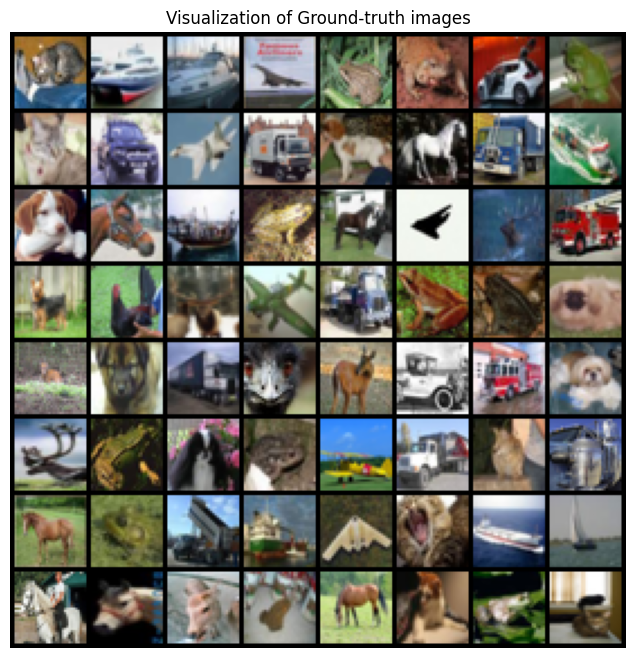

In [33]:
draw_sample_image(x[:batch_size//2], "Ground-truth images")

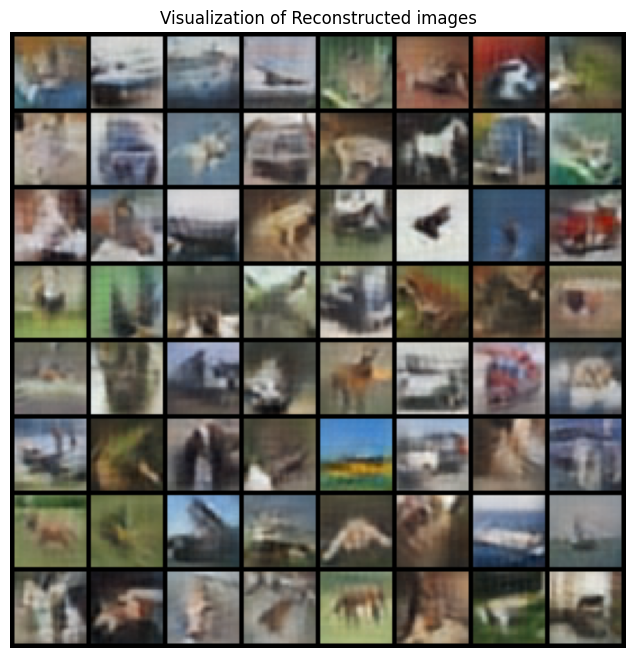

In [34]:
draw_sample_image(x_hat[:batch_size//2], "Reconstructed images")

### Step 6. Generate samples via random codes

In [35]:
def draw_random_sample_image(codebook, decoder, indices_shape):
    
    random_indices = torch.floor(torch.rand(indices_shape) * n_embeddings).long().to(DEVICE)
    codes = codebook.retrieve_random_codebook(random_indices)
    x_hat = decoder(codes.to(DEVICE))
    
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of Random Codes")
    plt.imshow(np.transpose(make_grid(x_hat.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

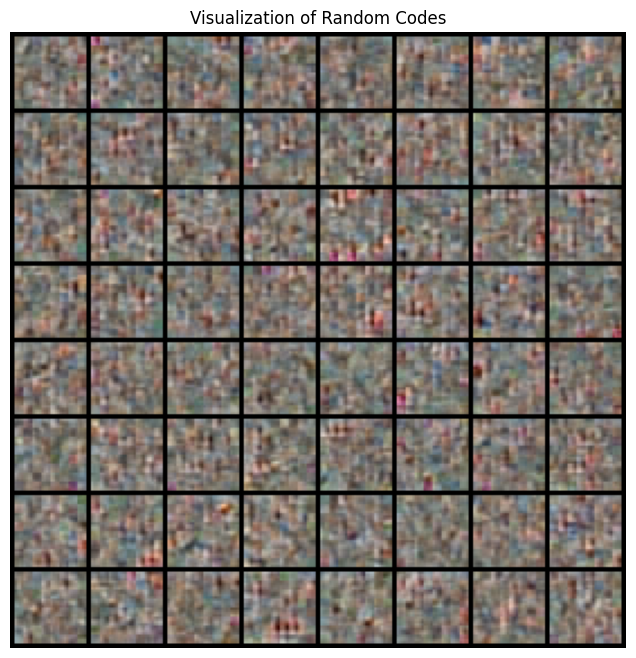

In [36]:
draw_random_sample_image(codebook, decoder, indices_shape=(batch_size//2, img_size[0]//4, img_size[1]//4))

In [37]:
torch.cuda.empty_cache()